In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt     
import re
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence 

from window_data import *

import os, errno
import sys
from tqdm import trange

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [76]:
breath_df = pd.read_pickle('breath_pickle')

In [77]:
under2 = breath_df[abs(breath_df['Csv_breath_holds']-breath_df['Data_breath_holds'])<=2]

In [78]:
under2 = under2[0:100]

In [79]:
under2.head(4)

,Trace,Csv_breath_holds,Data_breath_holds,Full_trace,breathhold_idx,bh_start_end
0,"[0.0003, 0.0006, 0.001, 0.0014, 0.0019, 0.0023...",31.29,31.69,"[0.0003, 0.0006, 0.001, 0.0014, 0.0019, 0.0023...","[2661, 2662, 2663, 2664, 2665, 2666, 2667, 266...","(2661, 5829)"
1,"[0.0006, 0.0009, 0.0013, 0.0017, 0.0022, 0.002...",30.61,31.40,"[0.0006, 0.0009, 0.0013, 0.0017, 0.0022, 0.002...","[2386, 2387, 2388, 2389, 2390, 2391, 2392, 239...","(2386, 5525)"
3,"[0.0013, 0.0027, 0.0034, 0.0041, 0.005, 0.006,...",30.85,31.84,"[0.0013, 0.0027, 0.0034, 0.0041, 0.005, 0.006,...","[2573, 2574, 2575, 2576, 2577, 2578, 2579, 258...","(2573, 5756)"
4,"[0.0012, 0.0015, 0.0019, 0.0023, 0.0029, 0.003...",32.12,32.53,"[0.0012, 0.0015, 0.0019, 0.0023, 0.0029, 0.003...","[2520, 2521, 2522, 2523, 2524, 2525, 2526, 252...","(2520, 5772)"


## Create Windowed Data

In [80]:
def split_trace(sequence, n_steps, n_output):
    X, y = list(), list()
    
    i = 0
    while i < len(sequence)-n_output:
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-n_output:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:end_ix+n_output]
        X.append(seq_x)
        y.append(seq_y)
        
        i += n_output
        
    return np.array(X), np.array(y)
    

In [145]:
t = [10, 11, 12,13,14,15,16,17,18,19,20]
split_trace(t,3,2)

(array([[10, 11, 12],
        [12, 13, 14],
        [14, 15, 16],
        [16, 17, 18]]),
 array([[13, 14],
        [15, 16],
        [17, 18],
        [19, 20]]))

In [81]:
num_outputs = 50

In [82]:
traces = []
next_pt = []
trace_num = []
i = 0
for row in under2['Trace']:
    Xs, ys = split_trace(row, 100, num_outputs)
    traces.append(Xs)
    next_pt.append(ys)
    trace_num.append(np.ones(len(Xs), dtype='int64')*i)
    i += 1

In [83]:
traces2 = [np.array(x, dtype='float32') for sublist in traces for x in sublist]
next_pt2 = [x for sublist in next_pt for x in sublist]
trace_num2 = [i for row in trace_num for i in row]

In [84]:
breath_df2 = pd.DataFrame({"Trace":traces2, "Next_pts": next_pt2, "Trace_num":trace_num2})

In [85]:
breath_df2.head()

,Trace,Next_pts,Trace_num
0,"[0.0003, 0.0006, 0.001, 0.0014, 0.0019, 0.0023...","[0.3095, 0.3149, 0.3203, 0.3257, 0.331, 0.3362...",0
1,"[0.0522, 0.056, 0.0598, 0.0638, 0.0678, 0.0718...","[0.5461, 0.55, 0.5538, 0.5575, 0.5612, 0.5649,...",0
2,"[0.3095, 0.3149, 0.3203, 0.3257, 0.331, 0.3362...","[0.7072, 0.7096, 0.7119, 0.714, 0.716, 0.7177,...",0
3,"[0.5461, 0.55, 0.5538, 0.5575, 0.5612, 0.5649,...","[0.7257, 0.7248, 0.7239, 0.7229, 0.7218, 0.720...",0
4,"[0.7072, 0.7096, 0.7119, 0.714, 0.716, 0.7177,...","[0.6169, 0.6139, 0.6108, 0.6077, 0.6045, 0.601...",0


## Train Test Split

In [86]:
df = breath_df2.copy()

In [87]:
df['Trace_num'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [88]:
train = df[df['Trace_num']>=51]
valid = df[(df['Trace_num']>=40) & (df['Trace_num']<51)]
test = df[df['Trace_num']<40]

In [89]:
X_train = train['Trace']
y_train = train['Next_pts']

X_val = valid['Trace']
y_val = valid['Next_pts']

X_test = test['Trace']
y_test = test['Next_pts']

## Scale Data

In [90]:
def normalize(x_train, x_val):
    u = np.mean([item for sublist in x_train for item in sublist])
    std = np.std([item for sublist in x_train for item in sublist])
    
    train = []
    for row in x_train:
        normalized_row = []
        for x in row:
            normalized_row.append((x-u)/std)
        train.append(normalized_row)
    
    val = []
    for row in x_val:
        normalized_row = []
        for x in row:
            normalized_row.append((x-u)/std)
        val.append(normalized_row)
    
    return train, val

In [91]:
x_train, x_val = normalize(X_train, X_val)

In [92]:
x_train, x_test = normalize(X_train, X_test)

## Reshape

In [93]:
def reshape_series(series):
    series = np.transpose(series)
    return series.reshape(series.shape[0],series.shape[1], 1)

In [94]:
x_train = reshape_series(x_train)
x_val = reshape_series(x_val)
x_test = reshape_series(x_test)

In [95]:
y_train2 = reshape_series(list(y_train))
y_val2 = reshape_series(list(y_val))
y_test2 = reshape_series(list(y_test))

## Initialize Data for Model

In [96]:
#dataset
from torch.utils.data import Dataset

In [97]:
class timeseries(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)
        self.len = x.shape[0]

    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
  
    def __len__(self):
        return self.len

In [98]:
dataset = timeseries(x_train,y_train2)
test_dataset = timeseries(x_val,y_val2)

In [100]:
final_test_dataset = timeseries(x_test,y_test2)

In [101]:
train_loader = DataLoader(dataset,shuffle=False,batch_size=200)
test_loader = DataLoader(test_dataset,shuffle=False,batch_size=200)

## Define LSTM Encoder and Decoder (Multistep Prediction)

In [102]:
# neural network
from torch import nn

class lstm_encoder(nn.Module):
    ''' Encodes a time series sequence '''
    
    def __init__(self, input_size=1, hidden_size=5, num_layers=1):

        super(lstm_encoder, self).__init__()
        self.input_size = input_size # the number of features in the input X
        self.hidden_size = hidden_size # the number of features in the hidden state h
        self.num_layers = num_layers # number of recurrent layers 
        
        # define an LSTM layer
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers)
        
    def forward(self, x):
        output, self.hidden = self.lstm(x.view(x.shape[0], x.shape[1], self.input_size))
        
        return output, self.hidden   # hidden gives the hidden state and cell state for the last element in the sequence 
                                     # give this to decoder
    
    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size),
                torch.zeros(self.num_layers, batch_size, self.hidden_size))
    
        

In [103]:
class lstm_decoder(nn.Module):
    ''' Decodes hidden state output by encoder '''
    
    def __init__(self, input_size=1, hidden_size=5, num_layers=1):

        super(lstm_decoder, self).__init__()
        self.input_size = input_size   # the number of features in the input X
        self.hidden_size = hidden_size # the number of features in the hidden state h
        self.num_layers = num_layers   # number of recurrent layers

        # Define LSTM layer and Linear layer
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                            num_layers = num_layers)
        self.linear = nn.Linear(hidden_size, input_size)       
    
    
    def forward(self, x, encoder_hidden_states):
        output, self.hidden = self.lstm(x.unsqueeze(0), encoder_hidden_states)
        output = self.linear(output.squeeze(0))     
        
        return output, self.hidden


## Define Model

In [104]:
class lstm_seq2seq(nn.Module):
    ''' train LSTM encoder-decoder and make predictions '''
    
    def __init__(self, input_size=1, hidden_size=5):

        super(lstm_seq2seq, self).__init__()

        self.input_size = input_size   # number of expected features in the input X
        self.hidden_size = hidden_size # number of features in the hidden state h
        
        # Encoder and decoder
        self.encoder = lstm_encoder(input_size=input_size, hidden_size=hidden_size)
        self.decoder = lstm_decoder(input_size=input_size, hidden_size=hidden_size)
        
    
    def train_model(self, input_tensor, target_tensor, n_epochs, target_len,batch_size,learning_rate = 0.01):
        losses = np.full(n_epochs, np.nan)

        optimizer = optim.Adam(self.parameters(), lr = learning_rate)
        criterion = nn.MSELoss()

        # calculate number of batch iterations
        n_batches = int(input_tensor.shape[1] / batch_size)

        with trange(n_epochs) as tr:
            for it in tr:
                batch_loss = 0.
  
                for b in range(n_batches):
                    # select data 
                    input_batch = input_tensor[:, b: b + batch_size, :]
                    target_batch = target_tensor[:, b: b + batch_size, :]

                    # outputs tensor
                    outputs = torch.zeros(target_len, batch_size, input_batch.shape[2])

                    # initialize hidden state
                    encoder_hidden = self.encoder.init_hidden(batch_size)

                    # zero the gradient
                    optimizer.zero_grad()

                    # encoder outputs
                    encoder_output, encoder_hidden = self.encoder(input_batch)

                    # decoder with teacher forcing
                    decoder_input = input_batch[-1, :, :]   # shape: (batch_size, input_size)
                    decoder_hidden = encoder_hidden

                    for t in range(target_len): 
                        decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                        outputs[t] = decoder_output
                        decoder_input = decoder_output

                    # compute the loss 
                    loss = criterion(outputs, target_batch)
                    batch_loss += loss.item()

                    # backpropagation
                    loss.backward()
                    optimizer.step()

                # loss for epoch 
                batch_loss /= n_batches 
                losses[it] = batch_loss

                # progress bar 
                tr.set_postfix(loss="{0:.3f}".format(batch_loss))

        return losses

        
    def predict(self, input_tensor, target_len):
        
        # encode input_tensor
        input_tensor = input_tensor.unsqueeze(1)     # add in batch size of 1
        encoder_output, encoder_hidden = self.encoder(input_tensor)

        # initialize tensor for predictions
        outputs = torch.zeros(target_len, input_tensor.shape[2])

        # decode input_tensor
        decoder_input = input_tensor[-1, :, :]
        decoder_hidden = encoder_hidden
        
        for t in range(target_len):
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            outputs[t] = decoder_output.squeeze(0)
            decoder_input = decoder_output
            
        np_outputs = outputs.detach().numpy()
        
        return np_outputs


## Best Model

In [106]:
mymodel = lstm_seq2seq(input_size=1, hidden_size=5)
print(f'Model Details - Hidden Size {5} \t Learning Rate: {0.001}')
train_loss = mymodel.train_model(dataset.x, dataset.y, n_epochs = 15, target_len = num_outputs, batch_size = 200, learning_rate = 0.001)
modname = 'lstm_encode_decode_' + '50'
torch.save(mymodel, modname)


Model Details - Hidden Size 5 	 Learning Rate: 0.001


100%|██████████| 15/15 [00:12<00:00,  1.21it/s, loss=0.622]


## Plots

In [107]:
mod = lstm_seq2seq(input_size=1, hidden_size=5)
mod = torch.load('lstm_encode_decode_50')

In [108]:
mod

lstm_seq2seq(
  (encoder): lstm_encoder(
    (lstm): LSTM(1, 5)
  )
  (decoder): lstm_decoder(
    (lstm): LSTM(1, 5)
    (linear): Linear(in_features=5, out_features=1, bias=True)
  )
)

In [109]:
def plot_train_test_results(lstm_model, Xtrain, Ytrain, Xtest, Ytest, unscaled_xtrain, unscaled_xtest, num_rows = 4):

    # input window size
    iw = Xtrain.shape[0]
    ow = Ytest.shape[0]

    # figure setup 
    num_cols = 2
    num_plots = num_rows * num_cols

    fig, ax = plt.subplots(num_rows, num_cols, figsize = (10, 13))

    # plot training/test predictionsabs
    for ii in range(num_rows):
        # train set
        xt = reshape_series(list(unscaled_xtrain))
        
        jj = np.random.randint(0, len(Xtrain))
        X_train_plt = Xtrain[:, jj, :]
        Y_train_pred = lstm_model.predict(torch.from_numpy(X_train_plt).type(torch.Tensor), target_len = ow)

        ax[ii, 0].plot(np.arange(0, iw), xt[:, jj, 0], 'k', linewidth = 2, label = 'Input')
        ax[ii, 0].plot(np.arange(iw - 1, iw + ow), np.concatenate([[xt[-1, jj, 0]], Ytrain[:, jj, 0]]),
                     color = (0.2, 0.42, 0.72), linewidth = 2, label = 'Target')
        ax[ii, 0].plot(np.arange(iw - 1, iw + ow),  np.concatenate([[xt[-1, jj, 0]], Y_train_pred[:, 0]]),
                     color = (0.76, 0.01, 0.01), linewidth = 2, label = 'Prediction')
        ax[ii, 0].set_xlim([0, iw + ow - 1])
        ax[ii, 0].set_xlabel('$t$')
        ax[ii, 0].set_ylabel('$y$')

        # test set
        xt = reshape_series(list(unscaled_xtest))
        X_test_plt = Xtest[:, jj, :]
        Y_test_pred = lstm_model.predict(torch.from_numpy(X_test_plt).type(torch.Tensor), target_len = ow)
        
        ax[ii, 1].plot(np.arange(0, iw), xt[:, jj, 0], 'k', linewidth = 2, label = 'Input')
        ax[ii, 1].plot(np.arange(iw - 1, iw + ow), np.concatenate([[xt[-1, jj, 0]], Ytest[:, jj, 0]]),
                     color = (0.2, 0.42, 0.72), linewidth = 2, label = 'Target')
        
        ax[ii, 1].plot(np.arange(iw - 1, iw + ow), np.concatenate([[xt[-1, jj, 0]], Y_test_pred[:, 0]]),
                      color = (0.76, 0.01, 0.01), linewidth = 2, label = 'Prediction')
        ax[ii, 1].set_xlim([0, iw + ow - 1])
        ax[ii, 1].set_xlabel('$t$')
        ax[ii, 1].set_ylabel('$y$')
        
        # Labels
        if ii == 0:
            ax[ii, 0].set_title('Train')

            ax[ii, 1].legend(bbox_to_anchor=(1, 1))
            ax[ii, 1].set_title('Test')

        plt.suptitle('LSTM Encoder-Decoder Prediction Examples', x = 0.445, y = 1.)
        plt.tight_layout()
        plt.subplots_adjust(top = 0.95)
        
        plt.savefig('prediction_examples4.png')


    return 

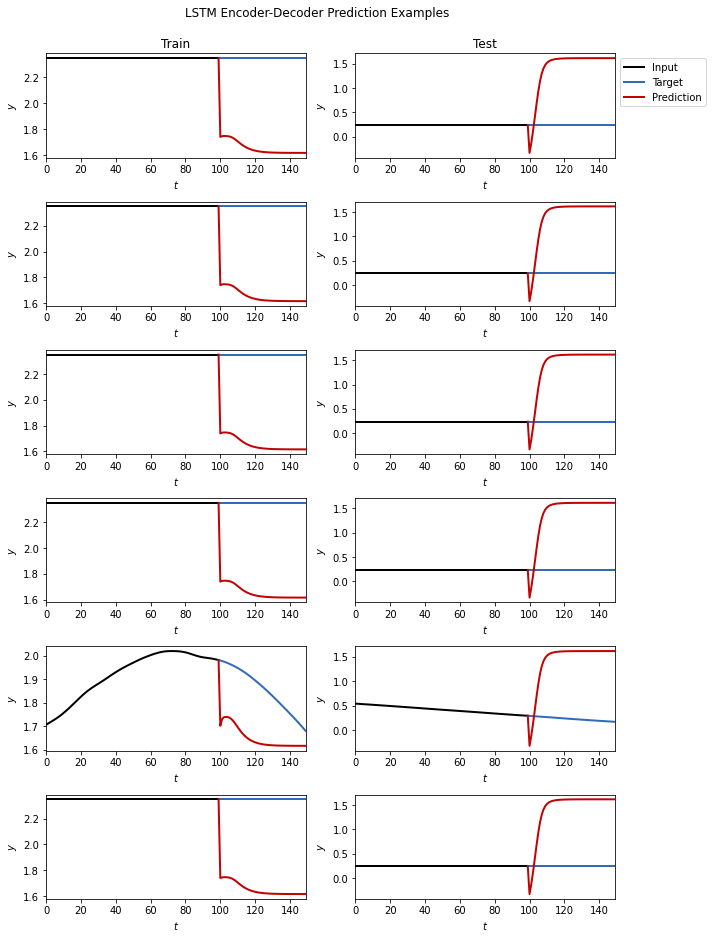

In [110]:
plot_train_test_results(mod, x_train, y_train2, x_val, y_val2, X_train, X_val, 6)

## Plots

In [111]:
final_test_dataset.x.shape

torch.Size([100, 4644, 1])

In [135]:
train_full_traces = train.groupby('Trace_num')['Next_pts'].apply(list)
valid_full_traces = valid.groupby('Trace_num')['Next_pts'].apply(list)
test_full_traces = test.groupby('Trace_num')['Next_pts'].apply(list)

In [136]:
def gather_preds(mymodel, dataset):
    preds = []
    for i in range(dataset.x.shape[1]):
        x_t = dataset.x[:, i, :]
        Y_pred = mymodel.predict(x_t, target_len = num_outputs)
        preds.append(Y_pred)
    return preds

In [137]:
test_preds = gather_preds(mod, final_test_dataset)
valid_preds = gather_preds(mod, test_dataset)
train_preds = gather_preds(mod, dataset)

In [146]:
train['preds'] = train_preds
valid['preds'] = valid_preds
test['preds'] = test_preds

<ipython-input-146-9221ef3f2022>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['preds'] = train_preds
<ipython-input-146-9221ef3f2022>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['preds'] = valid_preds
<ipython-input-146-9221ef3f2022>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

In [121]:
train.to_pickle("train_df_50.pkl")  
valid.to_pickle("valid_df_50.pkl")  
test.to_pickle("test_df_50.pkl")  

In [156]:
train.head(3)


,Trace,Next_pts,Trace_num,preds
6265,"[0.0002, 0.0006, 0.001, 0.0017, 0.0025, 0.0037...","[0.7513, 0.7615, 0.7716, 0.7817, 0.7917, 0.801...",51,"[[-0.15809974], [0.05758515], [0.31070963], [0..."
6266,"[0.2925, 0.3013, 0.3101, 0.319, 0.3279, 0.3369...","[1.2132, 1.2214, 1.2295, 1.2374, 1.2452, 1.252...",51,"[[0.6427573], [0.89818597], [1.1180383], [1.28..."
6267,"[0.7513, 0.7615, 0.7716, 0.7817, 0.7917, 0.801...","[1.6083, 1.6162, 1.624, 1.6319, 1.6399, 1.6478...",51,"[[1.2398167], [1.4341568], [1.5436797], [1.599..."


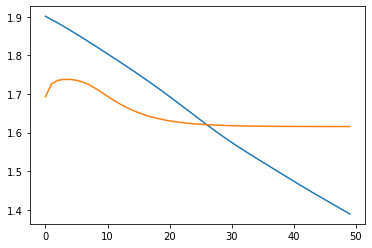

In [160]:
plt.plot(train['Next_pts'][6269])
plt.plot(train['preds'][6269])

In [161]:
train_full_traces = train.groupby('Trace_num')['Next_pts'].apply(list)
valid_full_traces = valid.groupby('Trace_num')['Next_pts'].apply(list)
test_full_traces = test.groupby('Trace_num')['Next_pts'].apply(list)

In [162]:
train_pred_trace = train.groupby('Trace_num')['preds'].apply(list)
valid_pred_trace = valid.groupby('Trace_num')['preds'].apply(list)
test_pred_trace = test.groupby('Trace_num')['preds'].apply(list)

ValueError: x and y can be no greater than 2D, but have shapes (110,) and (110, 50, 1)

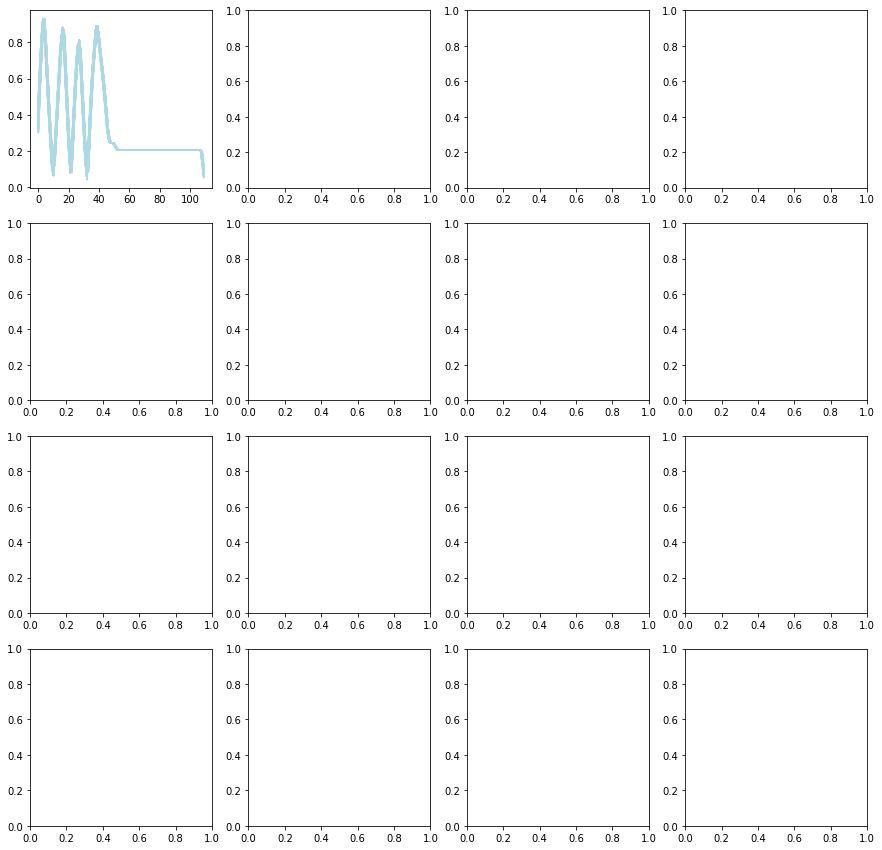

In [165]:
fig, axs = plt.subplots(4,4,figsize=(15,15))
for i in range(4):
    for j in range(4):
        idx = np.random.choice(test_full_traces.index)
        axs[i,j].plot(test_full_traces[idx], 'lightblue')
        axs[i,j].plot(test_pred_trace[idx], 'hotpink',linestyle='--')
plt.show()